In [1]:
from chapter1 import *
from chapter2 import minAcC
from time import time
import matplotlib.pyplot as plt

## 3. Two-dimensional partition functions using VUMPS

We can also construct the partition function of a two-dimensional Hamiltonian by considering for example the 2D Ising Hamiltonian. This is done by constructing a one-dimensional transfer matrix in the form of a matrix product operator (MPO), and noting that the partition function is then an (infinite) product of these transfer matrices, stacked vertically.

![transfer matrix](img/transferMPO.png)

As we will be working in the thermodynamic limit, it is again clear that we will be needing the leading eigenvectors of these transfer matrices, the fixed points. We also assume that the transfer matrix is properly normalised, such that the leading eigenvalue is 1.

### 2.1. Tensors

We start by defining the tensors that make up the transfer matrix for the Ising model. If we consider an infinite square lattice, we may simulate the model by placing a spin $1/2$ degree of freedom on each vertex, and then characterising the interactions by inserting a matrix $Q$ with Boltzmann weights on each of the edges. In the graphical language of tensor networks this corresponds to having a 4-legged 'Dirac delta tensor' on the vertices and a 2-legged $Q$ on the bonds.

If we want to rephrase this in terms of the transfer matrix we defined above, we split every bond interaction matrix over the two adjacent vertices and absorp them in the definition of $O$.

In [2]:
### vertices of Ising square lattice
def isingVertex(d, n):
    out = np.zeros( (d,) * n )
    out[tuple([np.arange(d)] * n)] = 1
    return out

### MPO tensor containing Boltzmann weights, distributed over all vertices equally
def isingO(beta, J):
    c, s = np.sqrt(np.cosh(beta*J)), np.sqrt(np.sinh(beta*J))
    Qsqrt = 1/np.sqrt(2) * np.array([[c+s, c-s],[c-s, c+s]])
    O = ncon((Qsqrt, Qsqrt, Qsqrt, Qsqrt, isingVertex(2,4)), ([-1,1], [-2,2], [-3,3], [-4,4], [1,2,3,4]))
    return O

### Magnetization tensor (unit cell of lattice)
def isingM(beta, J):
    Z = np.array([[1,0],[0,-1]])
    c, s = np.sqrt(np.cosh(beta*J)), np.sqrt(np.sinh(beta*J))
    
    ### square root known explicitly otherwise take square root of matrix numerically
    Qsqrt = 1/np.sqrt(2) * np.array([[c+s, c-s],[c-s, c+s]])
    vertexNew = ncon((Z, isingVertex(2,4)), ([-1,1], [1,-2,-3,-4]))
    M = ncon((Qsqrt, Qsqrt, Qsqrt, Qsqrt, vertexNew), ([-1,1], [-2,2], [-3,3], [-4,4], [1,2,3,4]))
    return M

### 2.2 MPS as an MPO fixed point
The partition function is given by contracting a tensor network consisting of all these rank 4 MPO tensors $O$, which have dimensions $(d,d,d,d)$. Whenever we contract such an infinite two-dimensional tensor network, we want to find the fixed point of the transfer matrix, such that we can collapse the vertical direction of the diagram.

Indeed, having found an MPS representation $|\Psi(A)>$ of the fixed point of $T(O)$, the partition function is evaluated to be

$$ \Lambda = <\Psi(A)| T |\Psi(A) > $$

Bringing the MPS in mixed canonical form, we write

![partition Function](img/partFunc.img)

### 2.3 Left and right fixed points
Again, contracting this infinite network requires that we find $F_L$ and $F_R$, such that we may now collapse the horizontal direction. These are found by considering the following diagrams:

![FL](img/FL.png)
![FR](img/FR.png)

Finally these are properly normalised if we set
![normal](img/FlFr.png)


In [3]:
def leftFixedPointMPO(Al, O, delta):
    D = Al.shape[0]
    d = Al.shape[1]
    transferLeftHandleMPO = lambda v: (ncon((v.reshape((D,d,D)), Al, np.conj(Al), O),([5, 3, 1], [1, 2, -3], [5, 4, -1], [3, 2, -2, 4]))).reshape(-1)
    transferLeftMPO = LinearOperator((D**2*d, D**2*d), matvec=transferLeftHandleMPO)
    lam, Fl = eigs(transferLeftMPO, k=1, which="LM", tol=delta/10)
    return lam, Fl.reshape((D,d,D))


def rightFixedPointMPO(Ar, O, delta):
    D = Ar.shape[0]
    d = Ar.shape[1]
    transferRightHandleMPO = lambda v: (ncon((v.reshape(D, d, D), Ar, np.conj(Ar), O), ([1, 3, 5], [-1, 2, 1], [-3, 4, 5], [-2, 2, 3, 4]))).reshape(-1)
    transferRightMPO = LinearOperator((D**2*d, D**2*d), matvec=transferRightHandleMPO)
    lam, Fr = eigs(transferRightMPO, k=1, which="LM", tol=delta/10)
    return lam, Fr.reshape((D,d,D))

### overlap to normalize the fixed points
def overlapFixedPointsMPO(Fl, Fr, C):
    overlap = ncon((Fl, Fr, C, np.conj(C)), ([1, 3, 2], [5, 3, 4], [2, 5], [1, 4]))
    return overlap

### 2.4 Optimize overlap using the VUMPS algorithm

We now want to reuse the VUMPS algorithm for optimizing the fixed point we used in the vertical direction, which is represented by an MPS.

To do so, we calculate the tangent-space projector and again find two terms that can be characterised by the maps

![OAc](img/OAc.png)
![OC](img/OC.png)

Again together with the consistency conditions, a fixed point is thus characterised by the set of equations:

$$ O_{A_C}(A_C) \sim A_C $$
$$ O_C(C) \sim C $$
$$ A_C = A_L C = CA_R $$

In [4]:
def OAc(X, Fl, Fr, O, lam):
    return ncon((Fl, Fr, X, O),([-1, 2, 1], [4, 5, -3], [1, 3, 4], [2, 3, 5, -2]))/lam


def OC(X, Fl, Fr):
    return ncon((Fl, Fr, X), ([-1, 3, 1], [2, 3, -2], [1, 2]))

Solving the eigenvalue equations gives us a new $\tilde{A}_C$ and $\tilde{C}$:

In [5]:
def calcNewCenterMPO(Ac, C, Fl, Fr, O, lam, delta):
    D = Fl.shape[0]
    d = Fl.shape[1]
    handleAc = lambda X: (OAc(X.reshape((D,d,D)), Fl, Fr, O, lam)).reshape(-1)
    handleAc = LinearOperator((D**2*d, D**2*d), matvec=handleAc)
    handleC = lambda X: (OC(X.reshape(D, D), Fl, Fr)).reshape(-1)
    handleC = LinearOperator((D**2, D**2), matvec=handleC)
    ### maximize overlap instead of minimizing the energy this time
    _, AcPrime = eigs(handleAc, k=1, which="LM", v0=Ac.reshape(-1), tol=delta/10)
    _, cPrime = eigs(handleC, k=1, which="LM", v0=C.reshape(-1), tol=delta/10)
    return AcPrime.reshape((D,d,D)), cPrime.reshape((D,D))

And after retrieving $\tilde{A}_C$ and $\tilde{C}$ we can recycle the same 'minAcC()' function to iterate the whole procedure until convergence. The partition function is eventually given by the left and right fixed point eigenvalue lambda. To check this we define some functions calculating the free energy and the magnetization for the simulation and the exact solution.

In [6]:
def freeEnergyDensity(beta, lam):
    return -np.log(lam) / beta


def isingMagnetization(beta, J, Ac, Fl, Fr):
    return ncon((Fl, Ac, isingM(beta, J), np.conj(Ac), Fr), ([1, 3, 2], [2,7,5],[3,7,8,6],[1,6,4], [5,8,4]))


def isingZ(beta, J, Ac, Fl, Fr):
    return ncon((Fl, Ac, isingO(beta, J), np.conj(Ac), Fr), ([1, 3, 2], [2,7,5],[3,7,8,6],[1,6,4], [5,8,4]))


def isingExact(beta, J):
    theta = np.arange(0, np.pi/2, 1e-6)
    x = 2 * np.sinh(2 * J * beta) / np.cosh(2 * J * beta) ** 2
    if 1 - (np.sinh(2 * J * beta)) ** (-4) > 0:
        magnetization = (1 - (np.sinh(2 * J * beta)) ** (-4)) ** (1 / 8)
    else:
        magnetization = 0
    free = -1 / beta * (np.log(2 * np.cosh(2 * J * beta)) + 1 / np.pi * np.trapz(np.log(1 / 2 * (1 + np.sqrt(1 - x ** 2 * np.sin(theta) ** 2))), theta))
    K = np.trapz(1 / np.sqrt(1 - x ** 2 * np.sin(theta) ** 2), theta)
    energy = -J * np.cosh(2 * J * beta) / np.sinh(2 * J * beta) * (1 + 2 / np.pi * (2 * np.tanh(2 * J * beta) ** 2 - 1) * K)
    return magnetization, free, energy

Calculating the partition function then becomes an iterative procedure.

In [7]:
def vumpsMPO(O, A, beta, J, delta, tol):

    ### test vumps for 2d ising partition function

    D = A.shape[0]
    d = A.shape[1]

    #critical point: beta =  0.440686793509772
    
    ### bring MPS in mixed gauge
    Al, Ac, Ar, C = mixedCanonical(A)

    flag = 1
    i = 0
    t0 = time()

    ### iteration
    while flag:
        lam, Fl = leftFixedPointMPO(Al, O, delta)
        _ , Fr = rightFixedPointMPO(Ar, O, delta)
        Fl /= overlapFixedPointsMPO(Fl, Fr, C)
        lam = np.real(lam)[0]
        AcTilde, cTilde = calcNewCenterMPO(Ac, C, Fl, Fr, O, lam, delta)
        AlTilde, AcTilde, ArTilde, cTilde = minAcC(AcTilde, cTilde)
        delta = np.linalg.norm(OAc(Ac, Fl, Fr, O, lam) - ncon((Al, OC(C, Fl, Fr)), ([-1, -2, 1], [1, -3])))
        Al, Ac, Ar, C = AlTilde, AcTilde, ArTilde, cTilde
        i += 1
        if delta < tol:
            flag = 0
    
    print('##############')
    print('T={}'.format(T))
    print('Time for VUMPS optimization:', time()-t0, 's')
    print('Iterations needed:', i)
    freeEnergy = freeEnergyDensity(beta, lam)
    freeEnergyExact = isingExact(beta, J)[1]
    print('Computed free energy:', freeEnergy)
    print('Exact free energy:', freeEnergyExact)
    print('##############')
    
    return Ac, C, Fl, Fr, lam

Some plots for the free energy density and the magnetization

Bond dimension: D = 12
##############
T=0.5
Time for VUMPS optimization: 0.350567102432251 s
Iterations needed: 3
Computed free energy: -2.0000000562178633
Exact free energy: -2.0000000563751583
##############
##############
T=0.5252525252525253
Time for VUMPS optimization: 0.37593579292297363 s
Iterations needed: 4
Computed free energy: -2.0000001266274197
Exact free energy: -2.0000001277978647
##############
##############
T=0.5505050505050505
Time for VUMPS optimization: 0.487307071685791 s
Iterations needed: 4
Computed free energy: -2.0000002690954997
Exact free energy: -2.0000002694087966
##############
##############
T=0.5757575757575758
Time for VUMPS optimization: 0.3012220859527588 s
Iterations needed: 3
Computed free energy: -2.0000005330001724
Exact free energy: -2.000000533157579
##############
##############
T=0.601010101010101
Time for VUMPS optimization: 0.5516321659088135 s
Iterations needed: 3
Computed free energy: -2.0000009994571686
Exact free energy: -2.000000998344

##############
T=1.5353535353535352
Time for VUMPS optimization: 0.1619853973388672 s
Iterations needed: 3
Computed free energy: -2.0098787758177648
Exact free energy: -2.0098788231039775
##############
##############
T=1.5606060606060606
Time for VUMPS optimization: 0.16652679443359375 s
Iterations needed: 3
Computed free energy: -2.011012468798005
Exact free energy: -2.011012518939535
##############
##############
T=1.5858585858585859
Time for VUMPS optimization: 0.16319060325622559 s
Iterations needed: 3
Computed free energy: -2.0122422731862653
Exact free energy: -2.012242326270745
##############
##############
T=1.6111111111111112
Time for VUMPS optimization: 0.16156935691833496 s
Iterations needed: 3
Computed free energy: -2.0135735670756225
Exact free energy: -2.0135736231902226
##############
##############
T=1.6363636363636362
Time for VUMPS optimization: 0.16041350364685059 s
Iterations needed: 3
Computed free energy: -2.015011906179873
Exact free energy: -2.0150119654115177


##############
T=2.5707070707070705
Time for VUMPS optimization: 0.20233511924743652 s
Iterations needed: 4
Computed free energy: -2.230115768307523
Exact free energy: -2.230115928103168
##############
##############
T=2.595959595959596
Time for VUMPS optimization: 0.19526219367980957 s
Iterations needed: 4
Computed free energy: -2.241803668931069
Exact free energy: -2.2418038180722175
##############
##############
T=2.621212121212121
Time for VUMPS optimization: 0.18984460830688477 s
Iterations needed: 4
Computed free energy: -2.2536660643729145
Exact free energy: -2.2536662096652758
##############
##############
T=2.6464646464646466
Time for VUMPS optimization: 0.1857316493988037 s
Iterations needed: 4
Computed free energy: -2.265693647266181
Exact free energy: -2.2656937910079593
##############
##############
T=2.6717171717171717
Time for VUMPS optimization: 0.18132734298706055 s
Iterations needed: 4
Computed free energy: -2.277877911327532
Exact free energy: -2.277878054346554
####

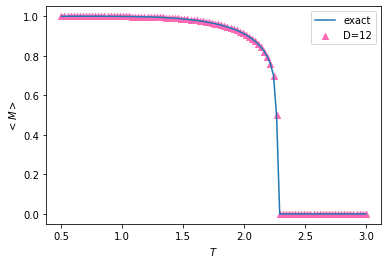

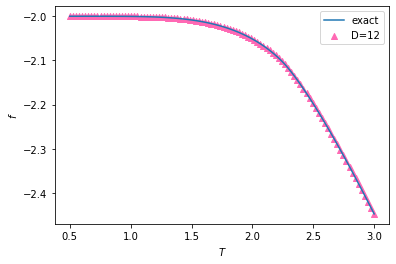

In [8]:
D = 12
d = 2
J = 1

print('Bond dimension: D =', D)

# optimization parameters
tol = 1e-5

A = createMPS(D, d)

T_array = np.linspace(0.5,3,100)
magnetizations = []
magnetizations_exact = []
frees = []
frees_exact = []

for T in T_array:
    beta = 1/T
    O = isingO(beta, J)
    t0 = time()
    delta = 1e-4
    flag = 1
    Ac, C, Fl, Fr, lam = vumpsMPO(O, A, beta, J, delta, tol)
            
    magnetizations.append(abs(isingMagnetization(beta, J, Ac, Fl, Fr)/isingZ(beta, J, Ac, Fl, Fr)))
    magnetizations_exact.append(isingExact(beta, J)[0])

    frees.append(freeEnergyDensity(beta, lam))
    frees_exact.append(isingExact(beta, J)[1])

plt.figure()
plt.grid
plt.xlabel(r'$T$')
plt.ylabel(r'$<M>$')
plt.scatter([T for T in T_array], magnetizations, label = 'D={}'.format(D), c="hotpink", marker="^")
plt.plot([T for T in T_array], magnetizations_exact, label = 'exact')
plt.legend()
plt.figure()
plt.grid
plt.xlabel(r'$T$')
plt.ylabel(r'$f$')
plt.scatter([T for T in T_array], frees, label = 'D={}'.format(D), c="hotpink", marker="^")
plt.plot([T for T in T_array], frees_exact, label = 'exact')
plt.legend()